<a href="https://colab.research.google.com/github/jmin07/Next-Frame-Prediction-Using-Beta-VAE/blob/main/visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contents
1. Common Function
2. Data Set
    - [Moving Mnist](https://www.cs.toronto.edu/~nitish/unsupervised_video/)
    - KTH
    - Driving DataSet
3. Visualization
    - Model Result
    - Linear latent variable

# 1. Common Function
세 개 데이터에서 공용으로 사용하는 라이브러리 호출 및 함수 작성

In [ ]:
from google.colab import drive

import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

# 설치가 필요한 라이브러리
!pip install tensorflow-addons

In [ ]:
# Mount your Google Drive
drive.mount('/content/drive')

In [ ]:
def regulizationAndSplict(X, Y, split_size=0.8, random_state=42, shuffle=False):
    """
    훈련 및 검증으로 분할하고 정규화를 하여 반환하는 함수.

    Parameters:
        - X: 학습 데이터(Input Data)
        - Y: 정답 데이터(Label Data)
        - split_size: 데이터를 분할하는 사이즈
        - random_state: 랜덤 상태 값.

    Returns:
        - sc_x_train
        - sc_x_test
        - sc_y_train
        - sc_y_test
    """

    # 훈련 데이터와 검증 데이터로 분할
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_size, random_state=random_state, shuffle=False)

    # 정규화
    X_sc_train = X_train.astype('float32') / 255.
    X_sc_test = X_test.astype('float32') / 255.
    y_sc_train = y_train.astype('float32') / 255.
    y_sc_test = y_test.astype('float32') / 255.

    # shape 맞추기
    sc_x_train = np.expand_dims(X_sc_train, axis=-1)
    sc_x_test = np.expand_dims(X_sc_test, axis=-1)
    sct_y_train = np.expand_dims(y_sc_train, axis=-1)
    sc_y_test = np.expand_dims(y_sc_test, axis=-1)

    return sc_x_train, sc_x_test, sc_y_train, sc_y_test



In [ ]:
def plot_sequence_with_target(X, y, index=0):
    """
    특정 인덱스의 이미지 시퀀스와 타겟 이미지를 시각화합니다.

    Parameters:
    - X: 이미지 시퀀스 데이터 (샘플 수, 시퀀스 길이, 높이, 너비)
    - y: 타겟 이미지 데이터 (샘플 수, 높이, 너비)
    - index: 시각화할 샘플의 인덱스
    """
    sequence_length = X.shape[1]

    fig, axes = plt.subplots(1, sequence_length + 1, figsize=(sequence_length * 2 + 2, 2))

    # 시퀀스의 이미지들을 표시
    for i, img in enumerate(X[index]):
        axes[i].imshow(img.squeeze(), cmap='gray')  # squeeze()는 채널 차원이 1인 경우 제거
        axes[i].axis('off')
        axes[i].set_title(f'Frame {i+1}')

    # 타겟 이미지 표시
    axes[-1].imshow(y[index].squeeze(), cmap='gray')
    axes[-1].axis('off')
    axes[-1].set_title('Target')

    plt.tight_layout()
    plt.show()

In [ ]:
def predict_image(X_test, encoder_model, translator_model, decoder_model):
    """
    모델의 예측 결과를 시각화 해주는 함수

    Parameters:
    - X: 이미지 시퀀스 데이터 (샘플 수, 시퀀스 길이, 높이, 너비)
    - y: 타겟 이미지 데이터 (샘플 수, 높이, 너비)
    - index: 시각화할 샘플의 인덱스
    """
    # 모델 예측
    new_arr = X_test[index][np.newaxis, ...]
    z_mean, z_log_var, z = encoder_model.predict(new_arr)
    x_last = tf.keras.layers.Lambda(lambda new_arr: new_arr[:, 4])(new_arr)
    x_output = translator_model(z)
    predicted_image = decoder_model.predict([x_last, x_output])

    # 예측 결과 시각화
    # 첫 번째 이미지의 예측 결과 시각화 (출력 데이터는 (64, 64, 1) 형태)
    plt.imshow(predicted_image[0, :, :, 0], cmap='gray')
    plt.title('Predicted Image')
    plt.axis('off') # 축 표시 안 함
    plt.show()


# 2. Data Set

## 2.1. Moving Mnist
- 10,000 sequences each of length 20 showing 2 digits moving in a 64 x 64 frame.

In [ ]:
def plot_mnist_sequence(sequence):
    """
    MNIST 이미지 시퀀스를 시각화합니다.
    """
    seq_length = sequence.shape[0]
    fig, axes = plt.subplots(1, seq_length, figsize=(seq_length * 2, 2))

    for i, img in enumerate(sequence):
        if axes.ndim == 1:
            ax = axes[i]
        else:
            ax = axes
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.show()

In [ ]:
def create_sequences(data, sequence_length=5):
    """
    연속된 이미지 시퀀스와 각 시퀀스의 다음 이미지(타겟)을 생성합니다.

    Parameters:
    - data: (샘플 수, 시퀀스 길이, 높이, 너비) 형태의 데이터
    - sequence_length: 하나의 시퀀스에 포함될 이미지 수

    Returns:
    - X: 생성된 이미지 시퀀스 데이터
    - y: 각 시퀀스에 대한 다음 이미지(타겟) 데이터
    """
    X, y = [], []
    num_samples, total_sequence_length, height, width = data.shape

    for sample_idx in range(num_samples):
        for start_idx in range(total_sequence_length - sequence_length):
            end_idx = start_idx + sequence_length
            sequence = data[sample_idx, start_idx:end_idx]
            target = data[sample_idx, end_idx]
            X.append(sequence)
            y.append(target)

    return np.array(X), np.array(y)

In [ ]:
# Specify the path to the file in your Google Drive
file_path = '/content/drive/MyDrive/05.학교/2023/01.논문/VAE/01_experiment/03_Data/moving_mnist/mnist_test_seq.npy'

data = np.load(file_path)
data = np.transpose(data, (1, 0, 2, 3))

In [ ]:
# 데이터 준비
sequence_length = 5
X, y = create_sequences(data, sequence_length)

print("X shape:", X.shape)
print("y shape:", y.shape)

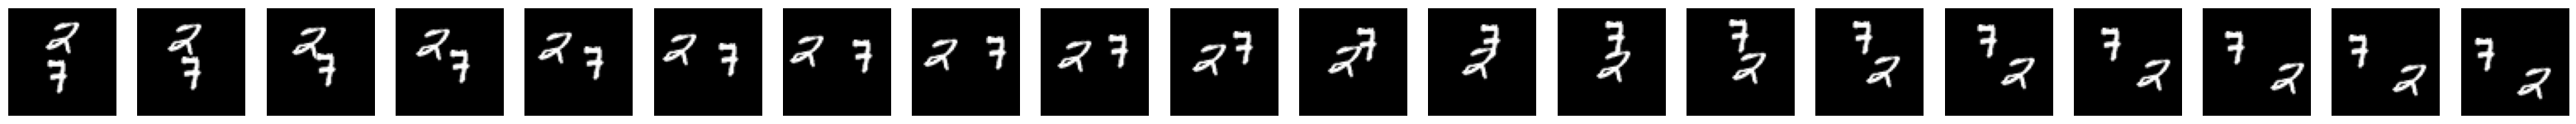

In [ ]:
# 첫 번째 샘플의 시퀀스 시각화
plot_mnist_sequence(data[0])

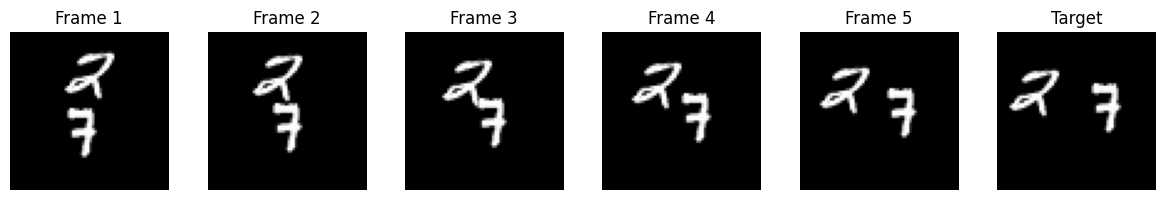

In [ ]:
plot_sequence_with_target(X_train, y_train, index=0)

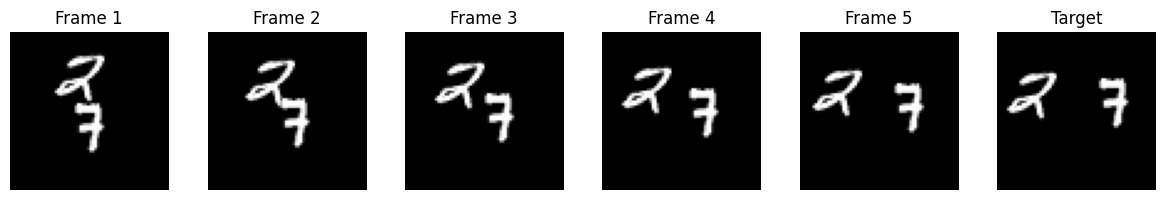

In [ ]:
plot_sequence_with_target(X_train, y_train, index=1)

### 시각화

### 모델 성능 확인

In [ ]:
def calculate_mse(y_true, y_pred):
    """
    두 이미지 간의 Mean Squared Error (MSE)를 계산합니다.

    Parameters:
    - y_true: 정답 이미지 (Height x Width x Channels) 형태의 numpy 배열
    - y_pred: 예측한 이미지 (Height x Width x Channels) 형태의 numpy 배열

    Returns:
    - mse: 계산된 MSE 값
    """
    # 두 이미지 간의 차이의 제곱을 계산하고, 그 평균을 취합니다.
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

calculate_mse(y_sc_test[80], predicted_image[0, :, :, 0])

0.0075167944

In [ ]:
def rescale_mse(normalized_mse, min_val=0, max_val=255):
    """
    정규화된 MSE를 원래의 데이터 스케일로 변환합니다.

    Parameters:
    - normalized_mse: 정규화된 데이터에 대한 MSE 값
    - min_val: 데이터의 원래 최소값 (정규화시 사용된 값)
    - max_val: 데이터의 원래 최대값 (정규화시 사용된 값)

    Returns:
    - original_mse: 원래 데이터 스케일로 변환된 MSE 값
    """
    scale_factor = (max_val - min_val) ** 2
    original_mse = normalized_mse * scale_factor

    return original_mse

# 예시 사용
normalized_mse = 0.007396373
original_mse = rescale_mse(normalized_mse)

print("Original scale MSE:", original_mse)

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(image1, image2):
    """
    두 이미지 간의 SSIM을 계산합니다.

    Parameters:
    - image1: 첫 번째 이미지 배열
    - image2: 두 번째 이미지 배열

    Returns:
    - ssim_index: 계산된 SSIM 값
    """
    # 이미지는 동일한 차원을 가져야 하며, 그레이스케일 또는 컬러 이미지 모두 처리 가능
    ssim_index, _ = ssim(image1, image2, full=True)
    return ssim_index


calculate_ssim(y_sc_test[80], predicted_image[0, :, :, 0])


In [ ]:
def rescale_image(data, min_val=0, max_val=255):
    """
    정규화된 이미지 데이터를 원래의 스케일로 되돌립니다.

    Parameters:
    - data: 정규화된 이미지 데이터 (numpy 배열)
    - min_val: 원래 데이터의 최소값
    - max_val: 원래 데이터의 최대값

    Returns:
    - rescaled_data: 원래 스케일로 변환된 이미지 데이터
    """
    rescaled_data = data * (max_val - min_val) + min_val
    return rescaled_data


In [ ]:
# 예시 데이터 생성

# 데이터를 원래 스케일로 되돌립니다.
original_data = rescale_image(predicted_image[0, :, :, 0], min_value, max_value)

calculate_mse(y_test[80], original_data)

### 모델 불러오기

In [ ]:
with tf.keras.utils.custom_object_scope({'GroupNormalization': tfa.layers.GroupNormalization}):

    # 모델 로드
    encoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/moving_mnist/encoder_30.h5')
    translator_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/moving_mnist/translator_30.h5')
    decoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/moving_mnist/decoder_30.h5')

In [ ]:
index = 80

# 모델 예측
new_arr = x_test_expanded[index][np.newaxis, ...]
z_mean, z_log_var, z = encoder_model.predict(new_arr)
x_last = tf.keras.layers.Lambda(lambda new_arr: new_arr[:, 4])(new_arr)
x_output = translator_model(z)

In [ ]:
print(z.shape)
print(x_output.shape)

(1, 16, 16, 32)
(1, 16, 16, 32)


## 2.2 KTH

In [ ]:
import cv2
import numpy as np

# 원하는 FPS 설정
target_fps = 30

frame_size = (64, 64)

# 프레임을 그룹화하여 데이터 구성
X = []  # 입력 데이터
y = []  # 레이블(예측할 다음 프레임)

# 각 비디오 파일에 대해 반복
for num in range(1, 72):
    frames = []  # 여러 비디오에서 추출한 프레임을 저장할 리스트

    video_path = '/content/drive/MyDrive/05.학교/2024/실험/01. DataSet/KTH/data' + str(num) + '.mp4'
    # 비디오 캡처 객체 생성
    cap = cv2.VideoCapture(video_path)

    # 원래 비디오의 FPS 확인
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    # 프레임 스킵 비율 계산 (원래 FPS가 타겟 FPS보다 높을 경우에만 적용)
    skip_rate = max(1, round(original_fps / target_fps))  # skip_rate가 최소 1이 되도록 설정

    frame_count = 0  # 읽은 프레임 수

    # 비디오에서 프레임 읽기
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 비디오 끝에 도달하면 반복문 종료

        # 원하는 FPS에 맞게 프레임 스킵
        if frame_count % skip_rate == 0:
            resized_frame = cv2.resize(frame, frame_size, interpolation=cv2.INTER_AREA)
            frames.append(resized_frame)

        frame_count += 1

    # 비디오 캡처 객체 해제
    cap.release()


    for i in range(len(frames) - 5):
        X.append(frames[i:i+5])  # 연속적인 5개의 프레임을 입력 데이터로 추가
        y.append(frames[i+5])    # 그 다음 프레임을 예측할 레이블로 추가

# 입력 데이터와 레이블을 numpy 배열로 변환
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 분할 비율 설정 (예: 80% 훈련, 20% 테스트)
train_size = 0.9

# 훈련 데이터와 검증 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42, shuffle=False)

In [ ]:
X_scale_train = X_train.astype('float32') / 255.
X_scale_test = X_test.astype('float32') / 255.
y_scale_train = y_train.astype('float32') / 255.
y_scale_test = y_test.astype('float32') / 255.

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow as tf
from keras.models import load_model
with tf.keras.utils.custom_object_scope({'GroupNormalization': tfa.layers.GroupNormalization}):

    # 모델 로드
    encoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/kth_0326/encoder_kth_150.h5')
    translator_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/kth_0326/translator_kth_150.h5')
    decoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/kth_0326/decoder_kth_150.h5')


In [ ]:
index = 205

1/1 [==============================] - 1s 714ms/step


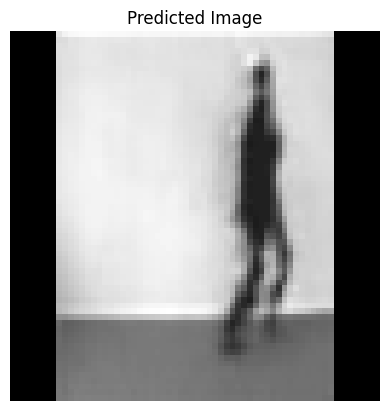

In [ ]:
# 모델 예측
new_arr = X_scale_test[index][np.newaxis, ...]
z_mean, z_log_var, z = encoder_model.predict(new_arr)
x_last = tf.keras.layers.Lambda(lambda new_arr: new_arr[:, 4])(new_arr)
x_output = translator_model(z)
predicted_image = decoder_model.predict([x_last, x_output])

# 예측 결과 시각화
# 첫 번째 이미지의 예측 결과 시각화 (출력 데이터는 (64, 64, 1) 형태)
plt.imshow(predicted_image[0, :, :, 0], cmap='gray')
plt.title('Predicted Image')
plt.axis('off') # 축 표시 안 함
plt.show()


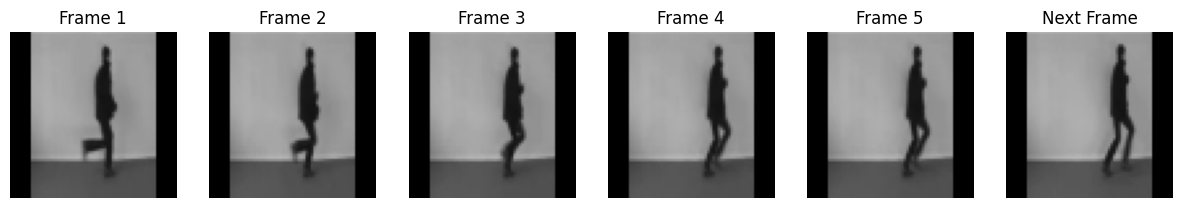

In [ ]:
import matplotlib.pyplot as plt

# 첫 번째 그룹의 프레임 시각화 (입력 데이터 X 중 첫 번째)
fig, axs = plt.subplots(1, 6, figsize=(15, 10))  # 5개의 연속 프레임과 1개의 예측 프레임을 위한 subplot 준비

for i, ax in enumerate(axs.flat[:5]):
    ax.imshow(cv2.cvtColor(X_test[index][i], cv2.COLOR_BGR2RGB))  # OpenCV는 BGR 형식을 사용하므로, RGB로 변환
    ax.set_title(f'Frame {i+1}')
    ax.axis('off')  # 축 제거

# 예측해야 할 다음 프레임(y 중 첫 번째) 시각화
axs.flat[5].imshow(cv2.cvtColor(y_test[index], cv2.COLOR_BGR2RGB))
axs.flat[5].set_title('Next Frame')
axs.flat[5].axis('off')

plt.show()

In [ ]:
def calculate_mse(y_true, y_pred):
    """
    두 이미지 간의 Mean Squared Error (MSE)를 계산합니다.

    Parameters:
    - y_true: 정답 이미지 (Height x Width x Channels) 형태의 numpy 배열
    - y_pred: 예측한 이미지 (Height x Width x Channels) 형태의 numpy 배열

    Returns:
    - mse: 계산된 MSE 값
    """
    # 두 이미지 간의 차이의 제곱을 계산하고, 그 평균을 취합니다.
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

calculate_mse(y_scale_test[index], np.squeeze(predicted_image))

In [ ]:
min_value = np.min(np.squeeze(predicted_image))
max_value = np.max(np.squeeze(predicted_image))

In [ ]:
def rescale_mse(normalized_mse, min_val=0, max_val=255):
    """
    정규화된 MSE를 원래의 데이터 스케일로 변환합니다.

    Parameters:
    - normalized_mse: 정규화된 데이터에 대한 MSE 값
    - min_val: 데이터의 원래 최소값 (정규화시 사용된 값)
    - max_val: 데이터의 원래 최대값 (정규화시 사용된 값)

    Returns:
    - original_mse: 원래 데이터 스케일로 변환된 MSE 값
    """
    scale_factor = (max_val - min_val) ** 2
    original_mse = normalized_mse * scale_factor
    return original_mse

# 예시 사용
normalized_mse = 0.0010535303

original_mse = rescale_mse(normalized_mse)
print("Original scale MSE:", original_mse)

In [ ]:
import numpy as np

def calculate_ssim(image1, image2):
    """
    두 이미지 간의 SSIM을 계산합니다.

    Parameters:
    - image1: 첫 번째 이미지 배열
    - image2: 두 번째 이미지 배열

    Returns:
    - ssim_index: 계산된 SSIM 값
    """
    # 이미지는 동일한 차원을 가져야 하며, 그레이스케일 또는 컬러 이미지 모두 처리 가능
    ssim_index, _ = ssim(image1, image2, full=True, multichannel=True)
    print(ssim_index)
    return ssim_index


calculate_ssim(y_scale_test[index], np.squeeze(predicted_image))

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(image1, image2):
    """
    두 이미지 간의 SSIM을 계산합니다.

    Parameters:
    - image1: 첫 번째 이미지 배열
    - image2: 두 번째 이미지 배열

    Returns:
    - ssim_index: 계산된 SSIM 값
    """
    # 이미지는 동일한 차원을 가져야 하며, 그레이스케일 또는 컬러 이미지 모두 처리 가능
    ssim_index = ssim(image1, image2, full=True)
    print(ssim_index)
    return ssim_index


calculate_ssim(y_scale_test[index], np.squeeze(predicted_image))

## 2.3 Driving DataSet

In [ ]:
import cv2
import numpy as np

# 원하는 FPS 설정
target_fps = 35

frame_size = (128, 128)

# 프레임을 그룹화하여 데이터 구성
X = []  # 입력 데이터
y = []  # 레이블(예측할 다음 프레임)

for num in range(1, 4):
    # 각 비디오 파일에 대해 반복
    frames = []  # 여러 비디오에서 추출한 프레임을 저장할 리스트

    video_path = '/content/drive/MyDrive/05.학교/2024/실험/01. DataSet/driving/video' + str(num) + '.mp4'
    # 비디오 캡처 객체 생성
    cap = cv2.VideoCapture(video_path)

    # 원래 비디오의 FPS 확인
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    # 프레임 스킵 비율 계산 (원래 FPS가 타겟 FPS보다 높을 경우에만 적용)
    skip_rate = max(1, round(original_fps / target_fps))  # skip_rate가 최소 1이 되도록 설정

    frame_count = 0  # 읽은 프레임 수

    # 비디오에서 프레임 읽기
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 비디오 끝에 도달하면 반복문 종료

        # 원하는 FPS에 맞게 프레임 스킵
        if frame_count % skip_rate == 0:
            resized_frame = cv2.resize(frame, frame_size, interpolation=cv2.INTER_AREA)
            frames.append(resized_frame)

        frame_count += 1

    # 비디오 캡처 객체 해제
    cap.release()

    for i in range(len(frames) - 5):
        X.append(frames[i:i+5])  # 연속적인 5개의 프레임을 입력 데이터로 추가
        y.append(frames[i+5])    # 그 다음 프레임을 예측할 레이블로 추가


# 입력 데이터와 레이블을 numpy 배열로 변환
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(6619, 5, 128, 128, 3)
(6619, 128, 128, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 분할 비율 설정 (예: 80% 훈련, 20% 테스트)
train_size = 0.9

# 훈련 데이터와 검증 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42, shuffle=False)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5957, 5, 128, 128, 3)
y_train shape: (5957, 128, 128, 3)
X_test shape: (662, 5, 128, 128, 3)
y_test shape: (662, 128, 128, 3)


In [ ]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

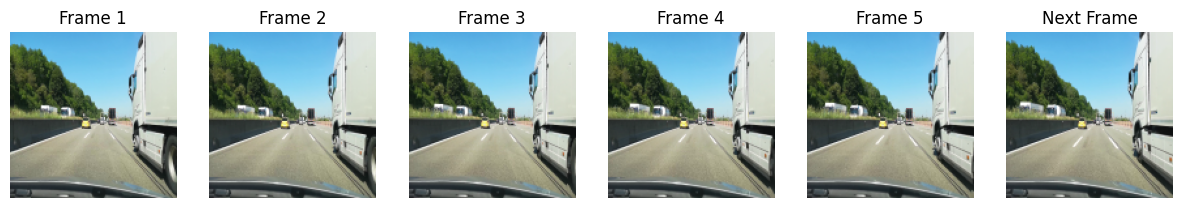

In [ ]:
import matplotlib.pyplot as plt

index = 2510

# 첫 번째 그룹의 프레임 시각화 (입력 데이터 X 중 첫 번째)
fig, axs = plt.subplots(1, 6, figsize=(15, 10))  # 5개의 연속 프레임과 1개의 예측 프레임을 위한 subplot 준비

for i, ax in enumerate(axs.flat[:5]):
    ax.imshow(cv2.cvtColor(X_train[index][i], cv2.COLOR_BGR2RGB))  # OpenCV는 BGR 형식을 사용하므로, RGB로 변환
    ax.set_title(f'Frame {i+1}')
    ax.axis('off')  # 축 제거

# 예측해야 할 다음 프레임(y 중 첫 번째) 시각화
axs.flat[5].imshow(cv2.cvtColor(y_train[index], cv2.COLOR_BGR2RGB))
axs.flat[5].set_title('Next Frame')
axs.flat[5].axis('off')

plt.show()

# 3. Visualization

## Model Result

### 1) Moving Mnist

In [ ]:
with tf.keras.utils.custom_object_scope({'GroupNormalization': tfa.layers.GroupNormalization}):

    # 모델 로드
    mnist_encoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/encoder_30.h5')
    mnist_translator_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/translator_30.h5')
    mnist_decoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/decoder_30.h5')


1/1 [==============================] - 2s 2s/step


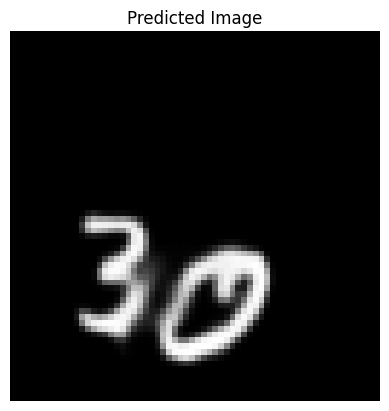

In [ ]:
predicted_image = decoder_model.predict([x_last, x_output])

# 예측 결과 시각화
# 첫 번째 이미지의 예측 결과 시각화 (출력 데이터는 (64, 64, 1) 형태)
plt.imshow(predicted_image[0, :, :, 0], cmap='gray')
plt.title('Predicted Image')
plt.axis('off') # 축 표시 안 함
plt.show()


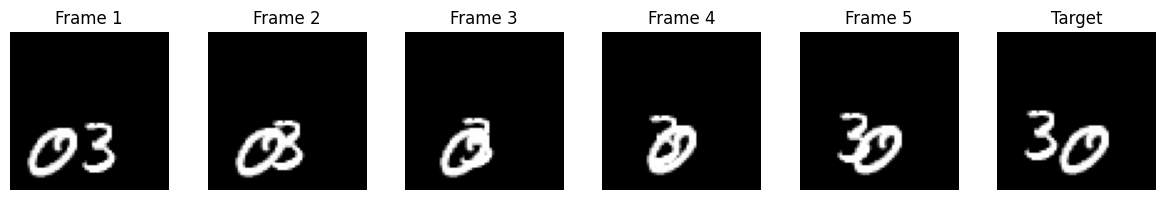

In [ ]:
plot_sequence_with_target(X_test, y_test, index=80)

### 2) KTH

1/1 [==============================] - 1s 674ms/step


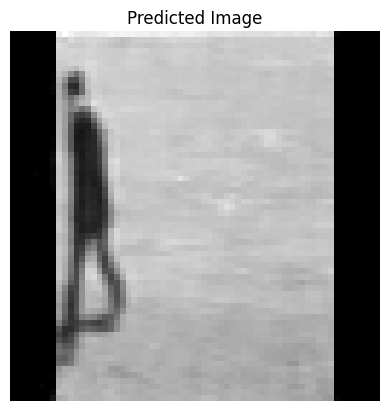

In [ ]:
with tf.keras.utils.custom_object_scope({'GroupNormalization': tfa.layers.GroupNormalization}):

    kth_encoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/encoder_kth_100.h5')
    kth_translator_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/translator_kth_100.h5')
    kth_decoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/decoder_kth_100.h5')

# 모델 예측
new_arr = X_test[index][np.newaxis, ...]
z_mean, z_log_var, z = encoder_model.predict(new_arr)
x_last = tf.keras.layers.Lambda(lambda new_arr: new_arr[:, 4])(new_arr)
x_output = translator_model(z)
predicted_image = decoder_model.predict([x_last, x_output])

# 예측 결과 시각화
# 첫 번째 이미지의 예측 결과 시각화 (출력 데이터는 (64, 64, 1) 형태)
plt.imshow(predicted_image[0, :, :, 0], cmap='gray')
plt.title('Predicted Image')
plt.axis('off') # 축 표시 안 함
plt.show()


### 3) Driving Dataset

## Linear Latent Variable

In [ ]:
index01 = 500
index02 = 501

In [ ]:
# 500번째 테스트 이미지
new_arr = X_test[index01][np.newaxis, ...]
z_mean, z_log_var, z01, x_128, x_64 = encoder_model.predict(new_arr)

In [ ]:
# 501번째 테스트 이미지
new_arr = X_test[index02][np.newaxis, ...]
z_mean, z_log_var, z02, x_128, x_64 = encoder_model.predict(new_arr)

In [ ]:
sq_z01 = np.squeeze(z01)
sq_z02 = np.squeeze(z02)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


pca = PCA(n_components=1)


for num in range(500, 511):
    sum = 0

    index01 = num
    index02 = index01 + 1

    new_arr01 = X_test[index02][np.newaxis, ...]
    new_arr02 = X_test[index02][np.newaxis, ...]

    z_mean, z_log_var, z01, x_128, x_64 = encoder_model.predict(new_arr01)
    z_mean, z_log_var, z02, x_128, x_64 = encoder_model.predict(new_arr02)

    sq_z01 = np.squeeze(z01)
    sq_z02 = np.squeeze(z02)

    for index in range(0, 128):

        z01_pca = pca.fit_transform(sq_z01[:, :, index])
        z02_pca = pca.fit_transform(sq_z02[:, :, index])

        print(z01_pca.shape)
        print(z02_pca.shape)

        model = LinearRegression().fit(z01_pca, z02_pca)
        score = model.score(z01_pca, z02_pca)

        # print(f"계수(a): {model.coef_[0][0]}, 절편(b): {model.intercept_[0]}")
        sum +=score

        # if (index == 1 or index == 2 or index == 3 or index == 4
        #     or index == 125 or index == 126 or index ==127):
        #     print(f"{index} 번째 채널의 회귀 모델의 R^2 점수: {score}")

    # print("index01 : " + str(index01))
    # print("index02 : " + str(index02))
    # print(sum / 128)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 가정: encoder_model, X_test, pca가 이미 정의되어 있음
# 각 PCA 변환 결과를 저장할 리스트 초기화
z01_pca_results = []
z02_pca_results = []

for num in range(500, 501):
    index01 = num
    index02 = index01 + 1

    new_arr01 = X_test[index02][np.newaxis, ...]
    new_arr02 = X_test[index02][np.newaxis, ...]

    z_mean, z_log_var, z01, x_128, x_64 = encoder_model.predict(new_arr01)
    z_mean, z_log_var, z02, x_128, x_64 = encoder_model.predict(new_arr02)

    sq_z01 = np.squeeze(z01)
    sq_z02 = np.squeeze(z02)

    # 각 특성에 대한 PCA 계산 및 결과 저장
    for index in range(0, 128):
        z01_pca = pca.fit_transform(sq_z01[:, :, index])
        z02_pca = pca.fit_transform(sq_z02[:, :, index])
        z01_pca_results.append(z01_pca)
        z02_pca_results.append(z02_pca)

# 시각화
plt.figure(figsize=(15, 8))
for i in range(len(z01_pca_results)):
    indices = np.arange(z01_pca_results[i].shape[0])
    plt.scatter(indices, z01_pca_results[i], label=f'z01_pca {i}')
    plt.scatter(indices, z02_pca_results[i], label=f'z02_pca {i}')

plt.title('PCA Transformations of z01 and z02 across multiple features')
plt.xlabel('Index')
plt.ylabel('PCA Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 범례를 그래프 바깥에 표시
plt.grid(True)
plt.show()


In [ ]:
pca = PCA(n_components=10)

index = 5

new_arr01 = X_test[index02][np.newaxis, ...]
z_mean, z_log_var, z01, x_128, x_64 = encoder_model.predict(new_arr01)

sq_z01 = np.squeeze(z01)
print(sq_z01.shape)

print(sq_z01[:, :, index].shape)

# fl_sq_z01 = sq_z01[:, :, index].flatten()
# print(fl_sq_z01.shape)

# rp_fl_sq_z01 = fl_sq_z01.reshape(1, -1)
# print(rp_fl_sq_z01.shape)

transformed_data = pca.fit_transform(sq_z01[:, :, index])

print(transformed_data.shape)
# for index in range(0, 1):
#     z01_pca = pca.fit_transform(sq_z01[:, :, index])

# print(z01_pca.shape)


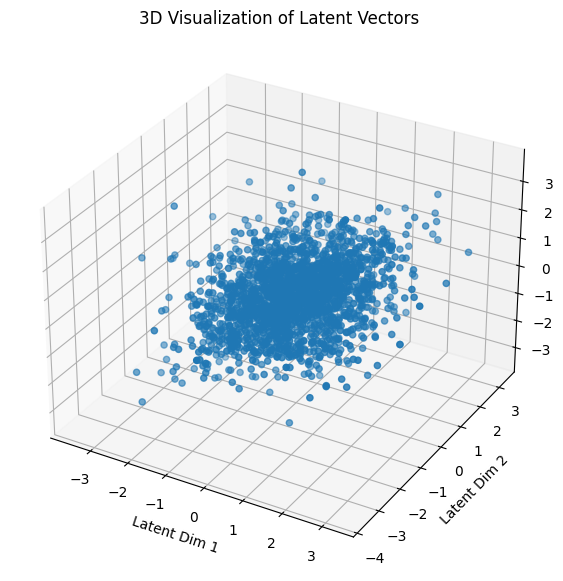

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 잠재 벡터 예시 데이터, shape: (데이터 개수, 잠재 공간 차원)
# 이 배열은 이미 학습된 Beta-VAE 모델로부터 얻은 잠재 벡터를 포함해야 합니다.
# 예를 들어, `latent_vectors = np.array([[1, 2, 3], [4, 5, 6], ...])`

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot 생성
ax.scatter(sq_z01[0], sq_z02[0], sq_z03[0])

ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_zlabel('Latent Dim 3')

# 제목 추가
ax.set_title('3D Visualization of Latent Vectors')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def linear_interpolate(z1, z2, num_steps=10):
    # z1과 z2 사이에 선형 보간을 수행합니다.
    return np.linspace(z1, z2, num_steps)

# 선형 보간
interpolated_latents = linear_interpolate(z01, z02, num_steps=30)

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i, latent in enumerate(interpolated_latents):
    ax[i].plot(latent)  # 생성된 이미지 대신 잠재 벡터를 플롯으로 표시
    ax[i].set_title(f"Step {i+1}")
    ax[i].axis('off')

plt.show()
